In [60]:
import gempy as gp
import os
import pymc3 as pm
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

## Create a simple model with Horizontal strata

Three layers model - from Jan's model. 6 surface points, 2 orien points

In [61]:
geo_model = gp.create_model('Tristrata')
gp.init_data(geo_model,[0,1000,0,1000,0,1000],resolution = [50,50,50],
                         path_o=os.pardir+"/My_model/input_data/model1_orientations.csv",
                         path_i=os.pardir+"/My_model/input_data/model1_surface_points.csv")



Active grids: ['regular']


Tristrata  2019-08-13 14:25

In [62]:
geo_model.get_data()

X    Y    Z     X_r     Y_r     Z_r surface  \
surface_points 0   100  200  600  0.2501  0.3126  0.5626   rock2   
               1   500  200  600  0.5001  0.3126  0.5626   rock2   
               2   900  200  600  0.7501  0.3126  0.5626   rock2   
               3   100  800  600  0.2501  0.6876  0.5626   rock2   
               4   500  800  600  0.5001  0.6876  0.5626   rock2   
               5   900  800  600  0.7501  0.6876  0.5626   rock2   
               6   100  200  400  0.2501  0.3126  0.4376   rock1   
               7   500  200  400  0.5001  0.3126  0.4376   rock1   
               8   900  200  400  0.7501  0.3126  0.4376   rock1   
               9   100  800  400  0.2501  0.6876  0.4376   rock1   
               10  500  800  400  0.5001  0.6876  0.4376   rock1   
               11  900  800  400  0.7501  0.6876  0.4376   rock1   
orientations   0   500  500  600  0.5001  0.5001  0.5626   rock2   
               1   500  500  400  0.5001  0.5001  0.4376   rock1   

                           series  id  order_series        smooth  \
surface_points 0   Default series   1             1  1.000000e-08   
               1   Default series   1             1  1.000000e-08   
               2   Default series   1             1  1.000000e-08   
               3   Default series   1             1  1.000000e-08   
               4   Default series   1             1  1.000000e-08   
               5   Default series   1             1  1.000000e-08   
               6   Default series   2             1  1.000000e-08   
               7   Default series   2             1  1.000000e-08   
               8   Default series   2             1  1.000000e-08   
               9   Default series   2             1  1.000000e-08   
               10  Default series   2             1  1.000000e-08   
               11  Default series   2             1  1.000000e-08   
orientations   0   Default series   1             1  1.000000e-02   
               1   Default series   2             1  1.000000e-02   

                            G_x           G_y  G_z  dip  azimuth  polarity  
surface_points 0            NaN           NaN  NaN  NaN      NaN       NaN  
               1            NaN           NaN  NaN  NaN      NaN       NaN  
               2            NaN           NaN  NaN  NaN      NaN       NaN  
               3            NaN           NaN  NaN  NaN      NaN       NaN  
               4            NaN           NaN  NaN  NaN      NaN       NaN  
               5            NaN           NaN  NaN  NaN      NaN       NaN  
               6            NaN           NaN  NaN  NaN      NaN       NaN  
               7            NaN           NaN  NaN  NaN      NaN       NaN  
               8            NaN           NaN  NaN  NaN      NaN       NaN  
               9            NaN           NaN  NaN  NaN      NaN       NaN  
               10           NaN           NaN  NaN  NaN      NaN       NaN  
               11           NaN           NaN  NaN  NaN      NaN       NaN  
orientations   0   1.000000e-12  1.000000e-12  1.0  0.0     90.0       1.0  
               1   1.000000e-12  1.000000e-12  1.0  0.0     90.0       1.0

 Setting and ordering the units and series

In [63]:
gp.map_series_to_surfaces(geo_model,{"Start_Series":('rock2','rock1'),"Basement_Series":('basement')})

,surface,series,order_surfaces,isBasement,color,id
0,rock2,Start_Series,1,False,#015482,1
1,rock1,Start_Series,2,False,#9f0052,2
2,basement,Basement_Series,1,True,#ffbe00,3


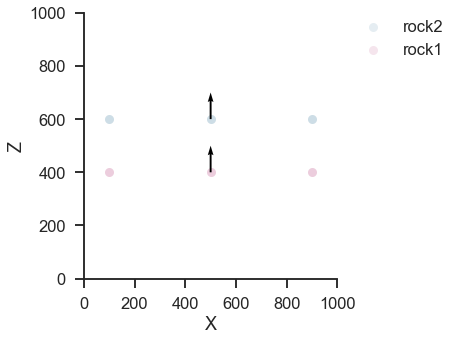

In [64]:
gp.plot.plot_data(geo_model,direction="y",scatter_kws={'alpha': 0.1})

In [65]:
gp.set_interpolation_data(geo_model, compile_theano=True,
                                        theano_optimizer='fast_compile',verbose=[])

Compiling theano function...
Compilation Done!


In [66]:
interp_data = gp.compute_model(geo_model)

/Users/zhouji/anaconda3/envs/Bayes/lib/python3.7/site-packages/gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: marching_cubes_lewiner() got an unexpected keyword argument 'mask'
  warnings.warn('Surfaces not computed due to: ' + str(e))


In [67]:
interp_data.surfaces.df

,surface,series,order_surfaces,isBasement,color,vertices,edges,id
0,rock2,Start_Series,1,False,#015482,NaN,NaN,1
1,rock1,Start_Series,2,False,#9f0052,NaN,NaN,2
2,basement,Basement_Series,1,True,#ffbe00,NaN,NaN,3


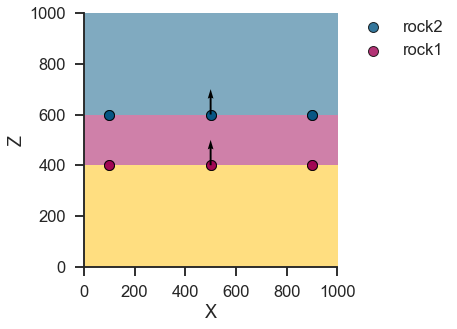

In [68]:
%matplotlib inline
gp.plot.plot_section(geo_model, cell_number=25,
                         direction='y', show_data=True,alpha= 0.5)

### Pymc3

Calculate the thickness of formation 2 (By Miguel)

In [73]:
#group the pd.dafaframe surface point by id
g = geo_model.surface_points.df.groupby('id')

def thickness(l2, l1):
    #define the location of surface point
    geo_model.modify_surface_points(g.groups[1], Z = l2)
    geo_model.modify_surface_points(g.groups[2], Z = l1)
    #re-run the model to update the grid
    gp.compute_model(geo_model)
    well = geo_model.solutions.lith_block.reshape(geo_model.grid.regular_grid.resolution)[10,1,:]
    #thickness calculated by the grid number * grid height
    thickness = (well == 2).sum()*geo_model.grid.regular_grid.dz
    return thickness

type(thickness(700,100))

numpy.float64

Probability model in Pymc3

In [93]:
import theano.tensor as tt

class MuFromTheta(tt.Op):
    itypes = [tt.dvector]
    otypes = [tt.dscalar]

    def perform(self, node, inputs, outputs):
        theta, = inputs
        mu = thickness(theta[0], theta[1])
        outputs[0][0] = np.array(mu)

        
tt_mu_from_theta = MuFromTheta()


In [94]:
with pm.Model() as model: 
    #define prior
    # r2 > r1
    r2 = pm.Normal('rock2', 600, 50)
    r1 = pm.Normal('rock1', 400, 50)
    theta = tt.as_tensor_variable([r2, r1])
    mu = pm.Deterministic('mu', tt_mu_from_theta(theta))
    #define likelihood
    a = pm.Normal('y', mu=mu, sd=20, observed=[200])
    trace = pm.sample(200, step = pm.Metropolis(), tune=50, cores=1, compute_convergence_checks=False)
    

Only 200 samples in chain.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [rock1]
>Metropolis: [rock2]
100%|██████████| 250/250 [15:13<00:00,  3.60s/it]


/Users/zhouji/anaconda3/envs/Bayes/lib/python3.7/site-packages/gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: marching_cubes_lewiner() got an unexpected keyword argument 'mask'
  warnings.warn('Surfaces not computed due to: ' + str(e))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c355dbc18>,
      dtype=object)

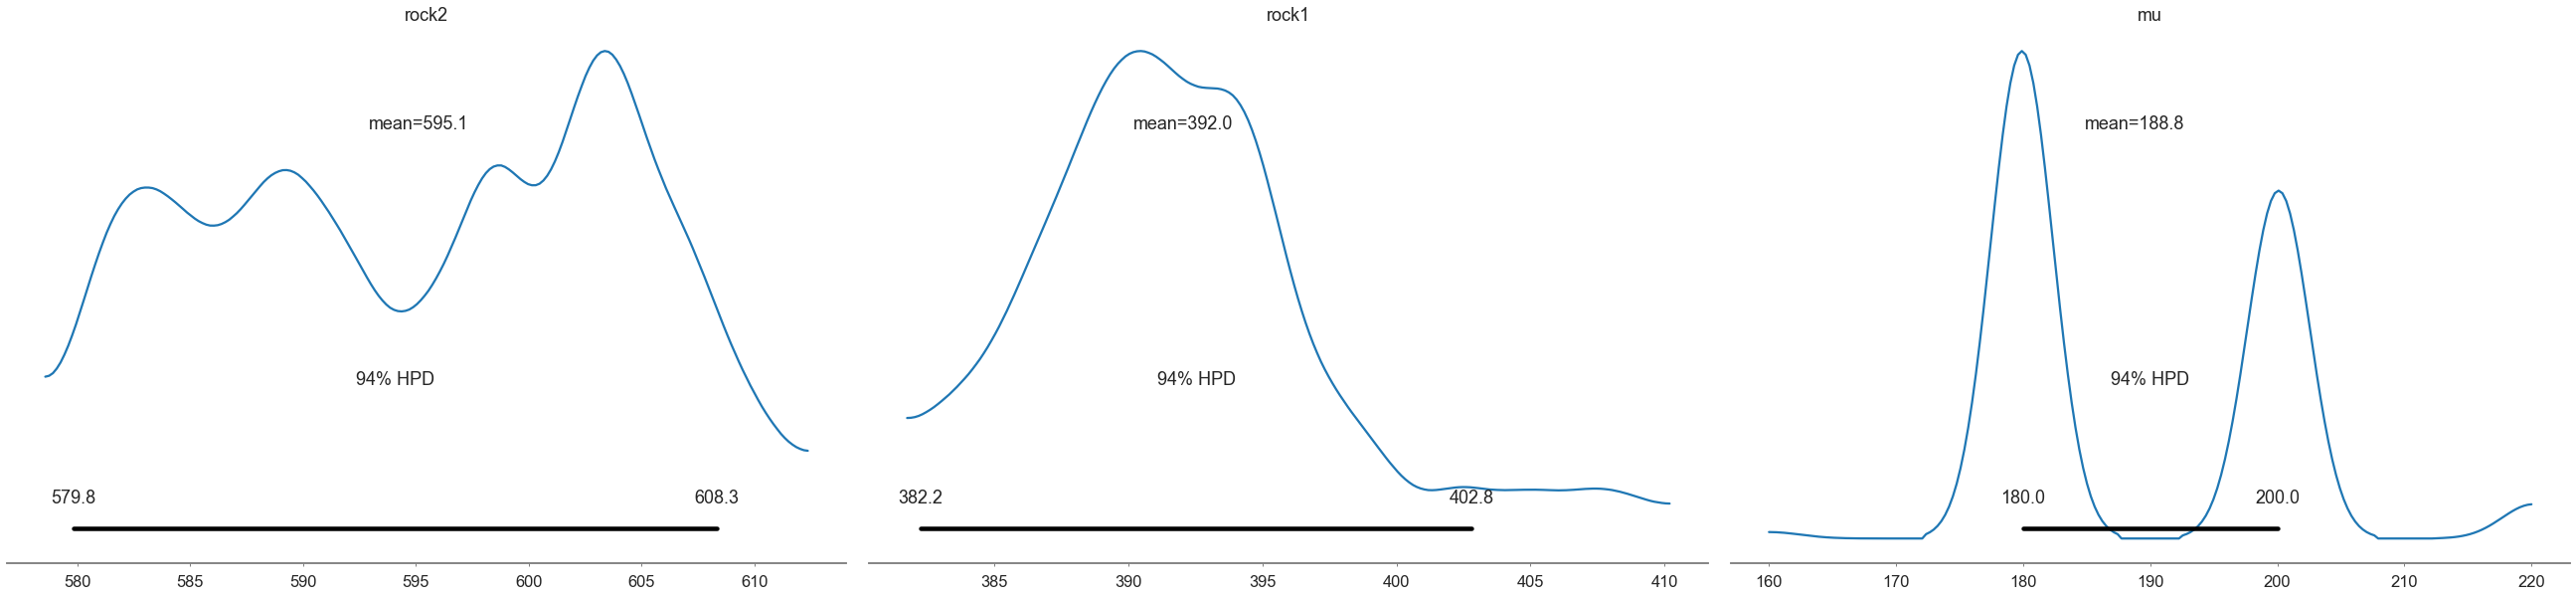

In [95]:
pm.plot_posterior(trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c355c4390>,
      dtype=object)

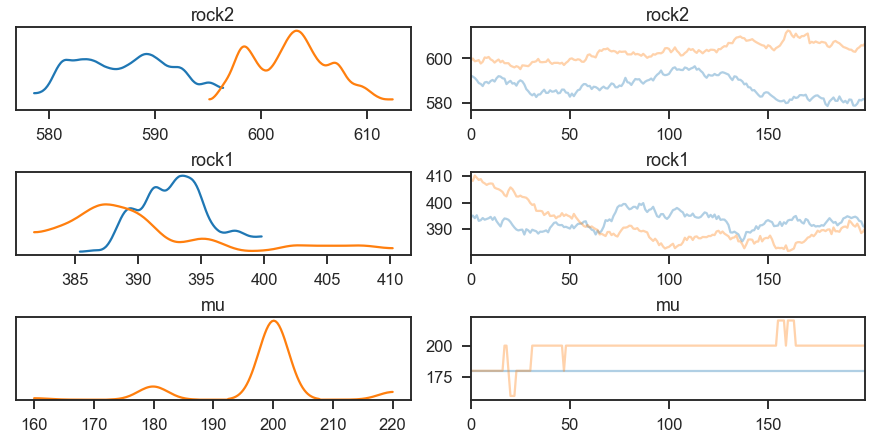

In [96]:
pm.traceplot(trace)

## Compling with Gempy --- Miguel

In [97]:
import theano
theano.config.compute_test_value = 'ignore'

In [99]:
i = geo_model.interpolator.get_python_input_block()

In [100]:
geo_model_T = theano.OpFromGraph(geo_model.interpolator.theano_graph.input_parameters_loop,
                               geo_model.interpolator.theano_graph.compute_series(), inline=False,
                                 on_unused_input='warn',
                               name='geo_model')

In [101]:
rf = geo_model.rescaling.df.loc['values', 'rescaling factor']
centers = geo_model.rescaling.df.loc['values', 'centers']

In [ ]:
# This is the new value for rock2
z_rock2 = 700

# We need to rescale
(z_rock2 - centers[2]) / rf + 0.5001

In [ ]:
# Now we need to change the input of the z of rock 2
i[4][g.groups[1], 2] = (z_rock2 - centers[2]) / rf + 0.5001
i[4]